# Calculate the inventory aging / slow moving items for given Dataset

In [1]:
# # Import different libraries

import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Import the inventory dataset

In [2]:
inventory_aging = pd.read_csv('Inventory management.csv')
inventory_aging.head()

,Serial number,Delivery_date,Delivery_month,UID,SKU,Delivery note,Category,QTY,COGS,Total COGS,Country Name
0,1,2022-06-22,2022-06,D968A0B0AF7F4313,SKU-D968A0B0AF7F4313,9844,Computing,24,14,336,Spain
1,2,2022-02-17,2022-02,E2C2BA20D9CA470F,SKU-E2C2BA20D9CA470F,9142,Computing,162,176,28512,France
2,3,2022-04-28,2022-04,A3DF8254C15541A4,SKU-A3DF8254C15541A4,4797,Phones,26,167,4342,Italy
3,4,2022-07-12,2022-07,EFC90FE5C39E4891,SKU-EFC90FE5C39E4891,5733,Phones,149,41,6109,Spain
4,5,2022-11-20,2022-11,21C60C83C87043A0,SKU-21C60C83C87043A0,8687,Computing,157,33,5181,Spain


In [3]:
# # Chaneg the date columns format

inventory_aging.Delivery_date= pd.to_datetime(inventory_aging.Delivery_date)
inventory_aging.Delivery_month= pd.to_datetime(inventory_aging.Delivery_month)

# Calculate the aging per days for the data

In [4]:
inventory_aging['Aging'] = inventory_aging['Delivery_date'].apply(lambda x: (datetime.datetime.now().date() - x.date()).days)
provision = inventory_aging
provision.head()

,Serial number,Delivery_date,Delivery_month,UID,SKU,Delivery note,Category,QTY,COGS,Total COGS,Country Name,Aging
0,1,2022-06-22,2022-06-01,D968A0B0AF7F4313,SKU-D968A0B0AF7F4313,9844,Computing,24,14,336,Spain,243
1,2,2022-02-17,2022-02-01,E2C2BA20D9CA470F,SKU-E2C2BA20D9CA470F,9142,Computing,162,176,28512,France,368
2,3,2022-04-28,2022-04-01,A3DF8254C15541A4,SKU-A3DF8254C15541A4,4797,Phones,26,167,4342,Italy,298
3,4,2022-07-12,2022-07-01,EFC90FE5C39E4891,SKU-EFC90FE5C39E4891,5733,Phones,149,41,6109,Spain,223
4,5,2022-11-20,2022-11-01,21C60C83C87043A0,SKU-21C60C83C87043A0,8687,Computing,157,33,5181,Spain,92


# Calculate the provision for the inventory assuming the company policy as below:

## .less than 90 days           = Zero provision
## .From 91 : 120 days        = 30% provision
## .From 121 : 180 days      = 60% provision
## .Over 180 days                = 100% provision


In [5]:
def a(provision):
    if provision['Aging'] <= 90:
        val = 0
    elif provision['Aging'] > 90 and provision['Aging'] <= 120:
        val = provision['Total COGS'] * .3
    elif provision['Aging'] > 120 and provision['Aging'] <= 180:
        val = provision['Total COGS'] * .6
    else:
        val = provision['Total COGS'] * 1
    return val

provision['inv_Provision'] = provision.apply(a, axis=1)
provision.head()

,Serial number,Delivery_date,Delivery_month,UID,SKU,Delivery note,Category,QTY,COGS,Total COGS,Country Name,Aging,inv_Provision
0,1,2022-06-22,2022-06-01,D968A0B0AF7F4313,SKU-D968A0B0AF7F4313,9844,Computing,24,14,336,Spain,243,336.0
1,2,2022-02-17,2022-02-01,E2C2BA20D9CA470F,SKU-E2C2BA20D9CA470F,9142,Computing,162,176,28512,France,368,28512.0
2,3,2022-04-28,2022-04-01,A3DF8254C15541A4,SKU-A3DF8254C15541A4,4797,Phones,26,167,4342,Italy,298,4342.0
3,4,2022-07-12,2022-07-01,EFC90FE5C39E4891,SKU-EFC90FE5C39E4891,5733,Phones,149,41,6109,Spain,223,6109.0
4,5,2022-11-20,2022-11-01,21C60C83C87043A0,SKU-21C60C83C87043A0,8687,Computing,157,33,5181,Spain,92,1554.3


# Show the provision for each Country per Category

In [6]:
country_provision = provision.pivot_table(index=['Country Name'], columns=['Category'], values=['inv_Provision'],aggfunc='sum')
country_provision

inv_Provision                                                    
Category         Computing  Electronics      Fashion   Furnitures       Phones
Country Name                                                                  
England        398664371.8  396513532.4  397860435.5  402285243.8  397254559.4
France         398627780.7  398771864.7  398081180.9  399698068.0  403007854.1
Germany        399569763.2  399022918.2  397808049.0  402742323.3  394950096.6
Italy          400585484.9  397255990.3  399780075.7  405874476.9  399069079.3
Poland         398592085.4  400145161.5  401543248.6  401170311.1  398654113.7
Portugal       400504585.3  402117244.4  403142941.1  399442964.0  401207241.1
Spain          395984284.6  401090752.1  399718104.1  396031552.2  398315174.8

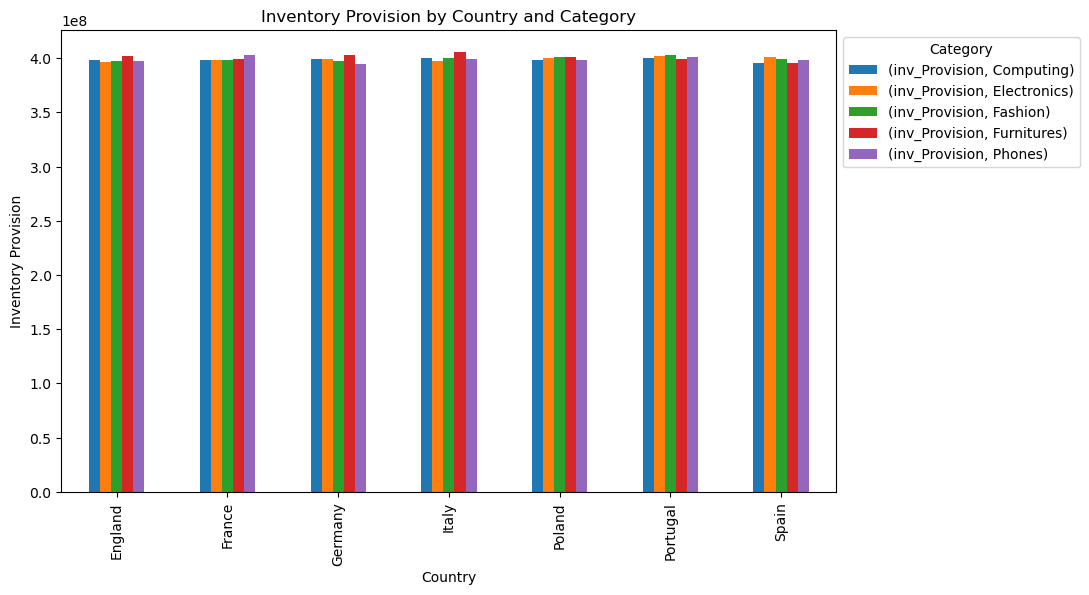

In [7]:
country_provision.plot(kind='bar', figsize=(10,6))
plt.title('Inventory Provision by Country and Category')
plt.xlabel('Country')
plt.ylabel('Inventory Provision')
plt.legend( title='Category',loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Get the highest provisioned SKUs 

In [8]:
SKU_provision = provision.groupby(['SKU', 'Category', 'Country Name']).agg({'inv_Provision': 'sum'})
SKU_provision.sort_values(by='inv_Provision', ascending=False).head(10)

,,,inv_Provision
SKU,Category,Country Name,
SKU-07DC089D726B40DD,Fashion,France,39601.0
SKU-24E9767AD83B4AAA,Computing,Italy,39601.0
SKU-E0F2EB1100C846ED,Phones,Spain,39601.0
SKU-98FC6E50D17B4461,Electronics,Italy,39601.0
SKU-B094E0E10850403E,Furnitures,Italy,39601.0
SKU-85B0B8E179F744E1,Phones,France,39601.0
SKU-D37FB9DA3DA74BD5,Electronics,Spain,39601.0
SKU-CB8164AC77A54578,Phones,England,39601.0
SKU-06DA84751F2D4220,Electronics,England,39601.0
